In [1]:
import numpy as np

import matplotlib.pyplot as plt
from funcs import plot_settings
plot_settings()

plt.rcParams["figure.figsize"] = (8, 8)

1 Преобразование Фурье

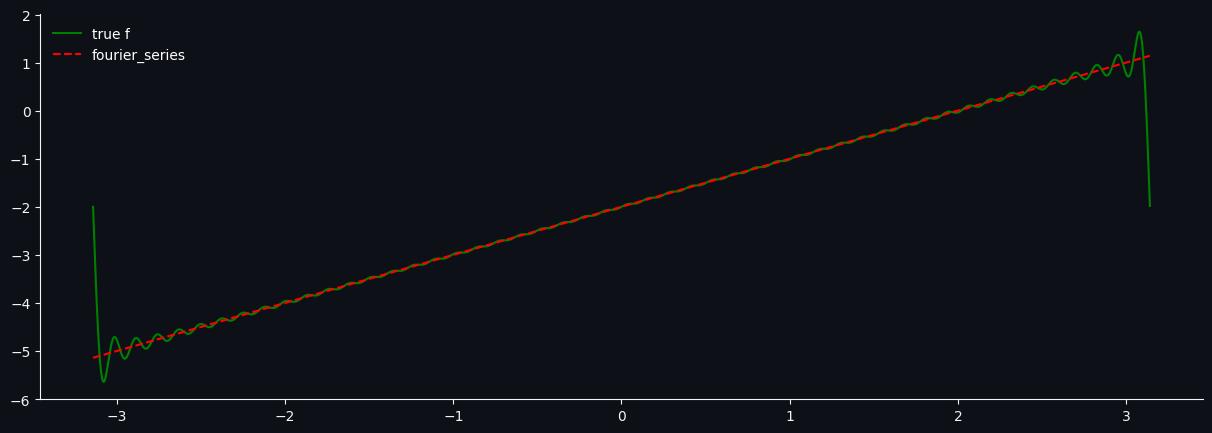

In [75]:
from scipy.integrate import quad

def f(x): return x - 2


x=np.arange(-np.pi,np.pi,0.001) 

y=f(x)


fc=lambda x:f(x)*np.cos(i*x)  
fs=lambda x:f(x)*np.sin(i*x)

n=50

An=[] 
Bn=[]
sum=0

for i in range(n):

    an=quad(fc,-np.pi,np.pi)[0]*(1.0/np.pi)
    An.append(an)

for i in range(n):

    bn=quad(fs,-np.pi,np.pi)[0]*(1.0/np.pi)
    Bn.append(bn)

for i in range(n):

    if i==0.0:
        sum=sum+An[i]/2
    else:
        sum=sum+(An[i]*np.cos(i*x)+Bn[i]*np.sin(i*x))

plt.plot(x,sum,'g', label="true f")

plt.plot(x,y,'r--', label='fourier_series')
plt.legend()
plt.show()

In [72]:
def get_furier_sol(x, f: callable, n):
    fc=lambda x:f(x)*np.cos(i*x)  
    fs=lambda x:f(x)*np.sin(i*x)

    An=[] 
    Bn=[]
    sum=0

    for i in range(n):

        an=quad(fc,-np.pi,np.pi)[0]*(1.0/np.pi)
        An.append(an)

    for i in range(n):

        bn=quad(fs,-np.pi,np.pi)[0]*(1.0/np.pi)
        Bn.append(bn)

    for i in range(n):

        if i==0.0:
            sum=sum+An[i]/2
        else:
            sum=sum+(An[i]*np.cos(i*x)+Bn[i]*np.sin(i*x))
    
    return sum

In [73]:
def ensemble_sol(x, f, ns=list(range(2, 11))):
    res = np.zeros((len(ns), len(x)))
    for i in range(len(ns)):
        res[i,:] = get_furier_sol(x, f, ns[i])
    
    return res.mean(0)

In [85]:
exact = f(x)
sol_e = ensemble_sol(x, f, list(range(2, 11)))
sol_o = get_furier_sol(x, f, 12)

In [86]:
from sklearn.metrics import mean_absolute_percentage_error

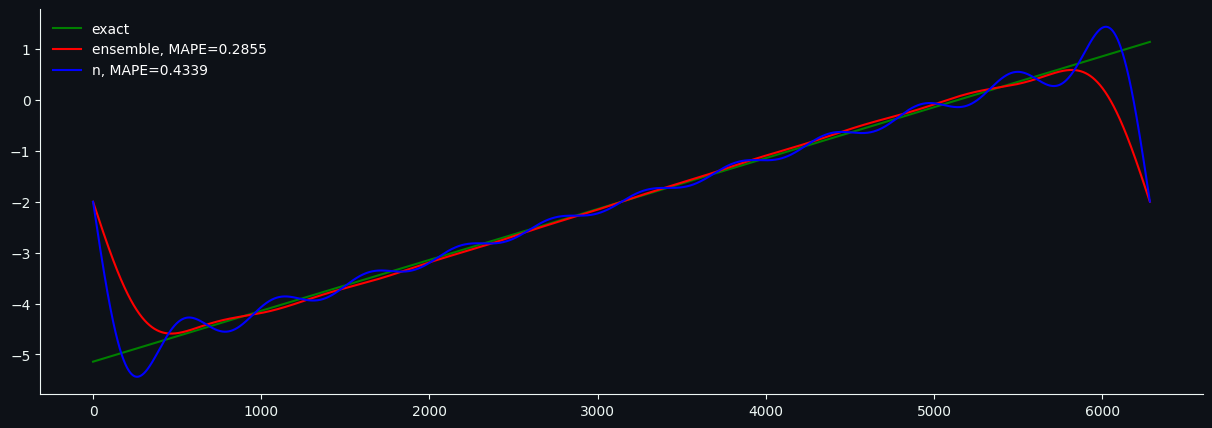

In [87]:
plt.plot(exact, label='exact')
plt.plot(sol_e, label=f'ensemble, MAPE={mean_absolute_percentage_error(exact, sol_e):.4f}')
plt.plot(sol_o, label=f'n, MAPE={mean_absolute_percentage_error(exact, sol_o):.4f}')
plt.legend()

Тихоновская

In [14]:
# заводим функции
# 1-v

mu = 8*1e5
f_0 = 300

x_ = lambda t: np.cos(2*np.pi*f_0*t + mu*t**2)

beta = 3*1e3

k_ = lambda t: np.exp(-beta*t)

size = 1000

a, b = 0, 0.01

t = np.linspace(a, b, size)

k = k_(t)
x_exact = x_(t)


### 1 решение прямой задачи

In [15]:
f = np.convolve(k, x_exact)

Text(0, 0.5, 'x')

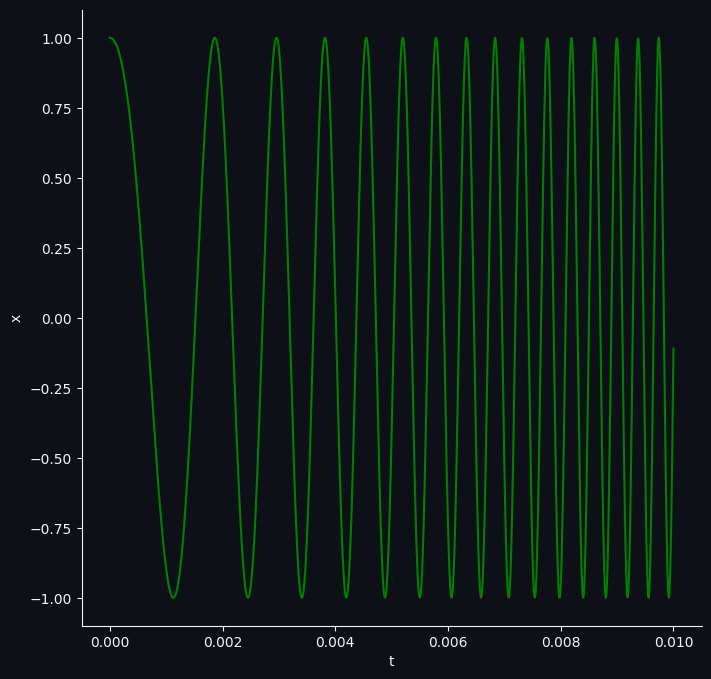

In [16]:
plt.plot(t, x_exact)
plt.xlabel("t")
plt.ylabel("x")

In [17]:
t_conv = np.linspace(a, (t[1]-t[0])*len(f), len(f))

Text(0.5, 1.0, 'convolve result')

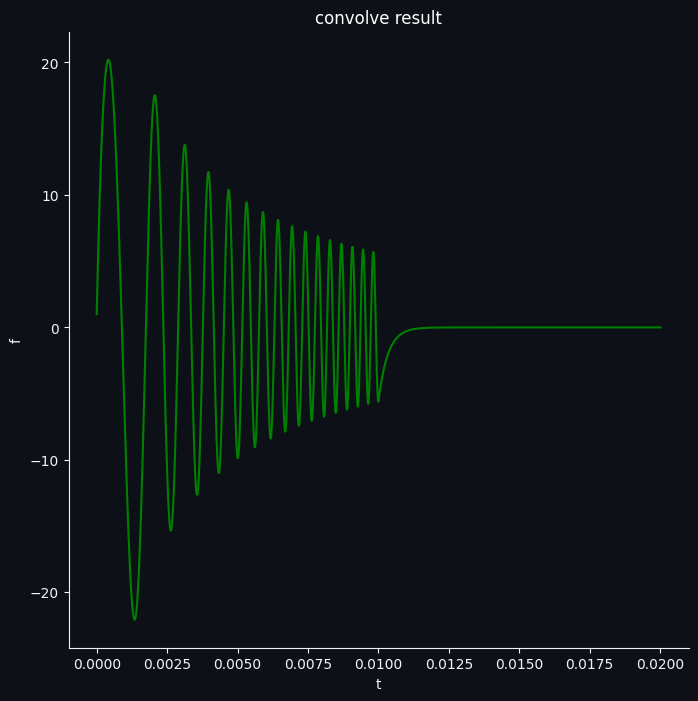

In [18]:
plt.plot(t_conv, f)
plt.xlabel("t")
plt.ylabel("f")
plt.title("convolve result", color='w')

### 2 добавить шум

In [19]:
from funcs import gaussian_noise

In [20]:
f_noise = f + gaussian_noise(f.shape)

In [21]:
from scipy.fft import fftfreq, fft, ifft

## 3 решение с регуляризацией Тихонова 

In [22]:
def tikhanov_regularization(f: np.ndarray, k: np.ndarray, t: np.ndarray,
                            alpha: float = 0.1, m = lambda o: np.abs(o)) -> np.ndarray:
    
    F = fft(f)
    K = fft(k, len(f))
    #print(f.shape[0], t[1] - t[0])
    omega = fftfreq(f.shape[0], d = t[1] - t[0])

    x_alpha_o = np.empty_like(f)
    # print(K.conjugate(), K)
    x_alpha_o = F * np.conjugate(K) / (np.conjugate(K) * K + alpha * m(omega))

    x_alpha = ifft(x_alpha_o)
    
    return np.real(x_alpha) 



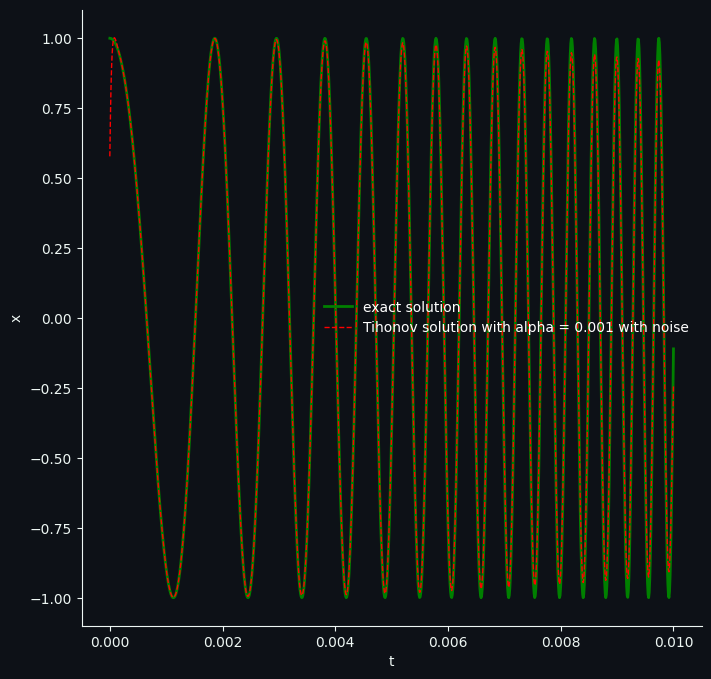

In [23]:
alp = 1e-3
x_sol = tikhanov_regularization(f, k, t, alp)
x_noise_sol = tikhanov_regularization(f_noise, k, t, alp)


#plt.plot(x_sol, label=f'Tihonov solution with alpha = {alp}')
plt.plot(t, x_exact, linewidth = 2, label='exact solution')
plt.plot(t, x_noise_sol[:t.shape[0]],'--', linewidth = 1, label=f'Tihonov solution with alpha = {alp} with noise')
plt.xlabel("t")
plt.ylabel("x")
plt.legend(labelcolor='w') 

### 4 Усреднение

In [25]:
from funcs import relative_error
from scipy import optimize
from typing import List

In [ ]:

    # func = lambda alpha: relative_error(x_exact, )
    # res = optimize.minimize(func, alpha_0, method="Powell")

In [48]:
plt.rcParams['figure.figsize'] = (15, 5)

In [49]:
def mean_f(sigma: float, mu: float = 0, alphas: List[float] = [1e-4,1e-5]) -> float:
    _f = f + gaussian_noise(f.shape, mu=mu, sigma=sigma)
    res = np.zeros((len(alphas), len(t)))
    for i in range(len(alphas)):
        res[i,:] = tikhanov_regularization(_f, k, t, alphas[i])[:t.size]

    return res.mean(axis=0)

In [70]:
x_sol_e = mean_f(1, 0, np.linspace(2*1e-3, 3*1e-3, 10))
x_sol_o = mean_f(1, 0, [1e-3])

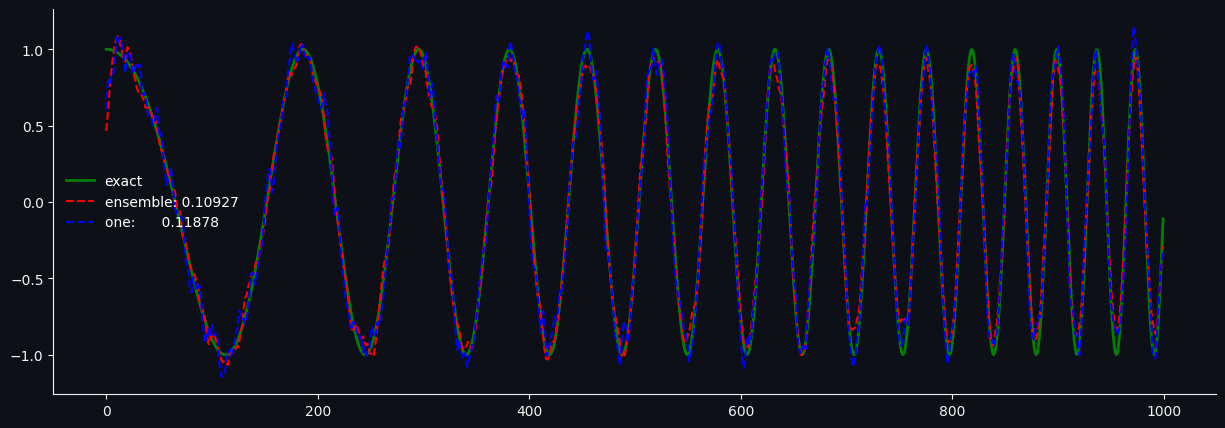

In [71]:
plt.plot(x_exact, linewidth=2, label='exact')
plt.plot(x_sol_e,'r--', label=f'ensemble: {relative_error(x_exact, x_sol_e):.5f}')
plt.plot(x_sol_o,'b--', label=f'one:      {relative_error(x_exact, x_sol_o):.5f}')

plt.legend()